In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [12]:
from tensorflow.keras.layers import Input, LSTM, Conv1D, Dropout, Dense, Add, Flatten, Reshape
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [13]:
with open("data/sin/sin_preprocessed_autoencoded.pickle", 'rb') as f:
    data = pickle.load(f)
autoencoded_X = np.array(data["autoencoded_X"]).reshape((-1, 100))
residuals_X = np.array(data["residuals_X"])
volume = np.array(data["volume"])
Y = np.array(data["Y"])

autoencoded_X.shape, residuals_X.shape, volume.shape, Y.shape

((9894, 100), (9894, 100), (9894, 100), (9894, 5))

In [14]:
X = []
for i in range(autoencoded_X.shape[0]):
    x = np.column_stack([autoencoded_X[i], residuals_X[i], volume[i]])
    X.append(x)

X = np.array(X)
Y = Y.reshape((-1, 5, 1))
X.shape, Y.shape

((9894, 100, 3), (9894, 5, 1))

In [15]:
train_size = int(len(X) * 0.8)
x_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

x_train.shape, y_train.shape

((7915, 100, 3), (7915, 5, 1))

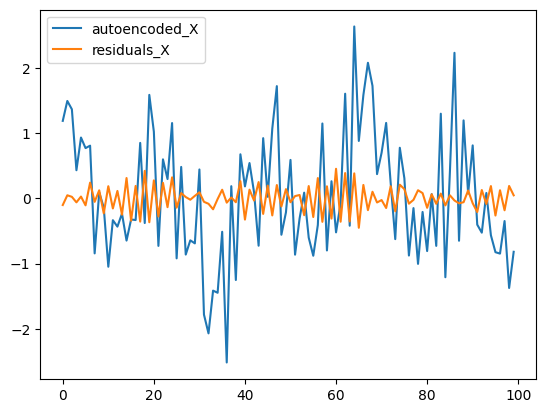

In [16]:
plt.plot(X[0,:,0])
plt.plot(X[0,:,1])
plt.legend(["autoencoded_X", "residuals_X"])
plt.show()

In [17]:
def block(input):
    lstm = LSTM(100, activation='tanh', return_sequences=False)(input)
    dense = Dense(200, activation='relu')(lstm)
    dropout = Dropout(0.2)(dense)
    reshaped = Reshape((100, 2))(dropout)
    conv = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(reshaped)
    output = Dense(3, activation='relu')(conv)

    output_reshaped = Reshape((100, 3))(output)
    output_with_residual = Add()([output_reshaped, input])

    return output_with_residual

input = Input(shape=(X.shape[1], X.shape[2]))
x = input
for _ in range(5):
    x = block(x)

x = Flatten()(x)
output = Dense(5, activation="sigmoid")(x)
model = Model(inputs=input, outputs=output)
model.summary()
# plot_model(model, show_shapes=True, show_layer_names=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100, 3)]             0         []                            
                                                                                                  
 lstm_5 (LSTM)               (None, 100)                  41600     ['input_2[0][0]']             
                                                                                                  
 dense_11 (Dense)            (None, 200)                  20200     ['lstm_5[0][0]']              
                                                                                                  
 dropout_5 (Dropout)         (None, 200)                  0         ['dense_11[0][0]']            
                                                                                            

In [18]:
adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.998, epsilon=1e-7, amsgrad=False)
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')

In [19]:
save_callback = ModelCheckpoint(
    "models/main/test1.keras",
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=0,
    save_weights_only=False,
    save_freq="epoch",
    initial_value_threshold=None,
)

In [20]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, min_lr=0.00001, verbose=1)

history = model.fit(x_train, y_train,
                    epochs=16, batch_size=256,
                    validation_data=(x_test, y_test),
                    callbacks=[reduce_lr, save_callback])


Epoch 1/16
31/31 [==============================] - 28s 790ms/step - loss: 1.0361 - val_loss: 0.8688 - lr: 0.0010
Epoch 2/16
31/31 [==============================] - 23s 738ms/step - loss: 0.8390 - val_loss: 0.8112 - lr: 0.0010
Epoch 3/16
31/31 [==============================] - 24s 771ms/step - loss: 0.8155 - val_loss: 0.8034 - lr: 0.0010
Epoch 4/16
31/31 [==============================] - 23s 750ms/step - loss: 0.8120 - val_loss: 0.8021 - lr: 0.0010
Epoch 5/16
31/31 [==============================] - 23s 741ms/step - loss: 0.8074 - val_loss: 0.7996 - lr: 0.0010
Epoch 6/16
31/31 [==============================] - 23s 747ms/step - loss: 0.8046 - val_loss: 0.7984 - lr: 0.0010
Epoch 7/16
31/31 [==============================] - 23s 749ms/step - loss: 0.8007 - val_loss: 0.7940 - lr: 0.0010
Epoch 8/16
31/31 [==============================] - 22s 727ms/step - loss: 0.7982 - val_loss: 0.7917 - lr: 0.0010
Epoch 9/16
31/31 [==============================] - 22s 725ms/step - loss: 0.7942 - val_

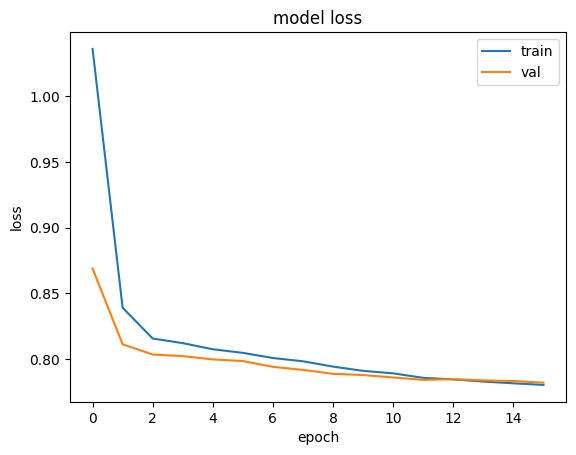

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

1/1 [==============================] - 1s 1s/step


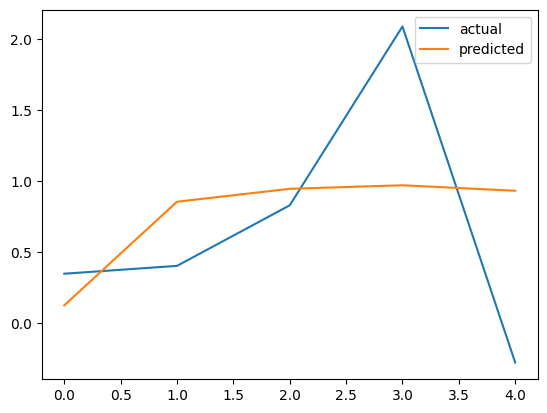

In [22]:
model = load_model('models/main/test1.keras')

plt.plot(y_test[-1])
plt.plot(model.predict(x_test[-1:])[0])
plt.legend(["actual", "predicted"], loc='upper right')
plt.show()